# Machine Learning in Marketing by Python

## 1. Churn Predictions

### Introduction & Data Cleaning

**Churn**
- Churn happens when a customer stop doing business with a company, and it could also apply when subscribers cancel or don't renew the subscription. 
- The business context could be *contractual* or *non-contractual*. Contractual churn apply to business involved with subscription and has explicit terminal of the purchase while the other involved with uncontinuos business without explicit periods and customer decision which could be harder to be analyzed
- *Voluntary* or *involuntary* churn: the former happens when customers decide to stop buying or engaging, the latter is that customers fail to engage in using the service or renewing.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression

In [2]:
telco = pd.read_csv('telco.csv')
print(telco.head(5))

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [3]:
telco_raw = telco.copy()

# print the data types
print(telco_raw.dtypes)

# print the header
print(telco_raw.head(3))

# print unique values of each column
print(telco_raw.nunique())

# check the proportion of missing data
telco_raw.isnull().mean()

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [4]:
# Store numerical and categorical data

## change data type

## store customerId and Churn column names
custid = ['customerID']
target = ['Churn']

## store categorical column names
categorical = telco_raw.nunique()[telco_raw.nunique()<5].keys().tolist()
categorical.remove(target[0])
categorical.remove('SeniorCitizen')
print(f'Categorical columns: {categorical}')
print()

## store numerical column names
numerical = [col for col in telco_raw.columns
                 if col not in custid + target + categorical]
numerical.remove('SeniorCitizen')
print(f'Numerical columns: {numerical}')

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Numerical columns: ['tenure', 'MonthlyCharges', 'TotalCharges']


In [5]:
# check numerical columns' property
print(telco_raw[numerical].describe())

# convert to numerical datatype
telco_raw['TotalCharges'] = pd.to_numeric(telco_raw['TotalCharges'], errors = 'coerce')
print(telco_raw['TotalCharges'].describe())

# drop na values
telco_raw = telco_raw.dropna(axis=0)

print(telco_raw.describe())

            tenure  MonthlyCharges
count  7043.000000     7043.000000
mean     32.371149       64.761692
std      24.559481       30.090047
min       0.000000       18.250000
25%       9.000000       35.500000
50%      29.000000       70.350000
75%      55.000000       89.850000
max      72.000000      118.750000
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64
       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7032.000000  7032.000000     7032.000000   7032.000000
mean        0.162400    32.421786       64.798208   2283.300441
std         0.368844    24.545260       30.085974   2266.771362
min         0.000000     1.000000       18.250000     18.800000
25%         0.000000     9.000000       35.587500    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000 

While trying to examine properties of numerical columns, there is only information of two columns showing, and column `TotalCharges` is missing. Which means that TotalCharges needs to be changed its datatype.Therefore, I converted this column by its datatype, from string to float, and to ensure all the value can be changed to numerical values, I set the false one to coerce. After the cleaning process, the entire dataset has 7032 rows instead of original 7043 rows.

In [6]:
# perform one-hot encoding to categorical variables
telco_raw = pd.get_dummies(data=telco_raw, columns = categorical+['Churn'], drop_first = True)

# initialize StandardScaler
scaler = StandardScaler()

# fit and transform the scaler on numerical columns
scaled_numerical = scaler.fit_transform(telco_raw[numerical])
telco_raw[numerical] = scaled_numerical
#scaled_numerical = pd.DataFrame(scaled_numerical, columns = numerical)

# change column name
telco_raw.rename(columns={'Churn_Yes':'Churn'}, inplace= True)

### (1) Predict Churn with Decision Tree

The dicision tree is proned to over-fitting, since it will memorize the pattern and use it down to observation level

In [21]:
# Preparing training and testing data

# obtain features X 
X = telco_raw.copy()
X = X.drop(columns = ['Churn', 'customerID'])
X = shuffle(X, random_state=2022)

# obtain Y
Y = telco_raw.copy()['Churn']
#Y = pd.get_dummies(data=Y, drop_first=True)
Y = shuffle(Y, random_state=2022)

In [8]:
# split X and Y into training and testing datasets
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.25, random_state = 2022) 

# ensure the proportion of training data and testing data are 75% and 25%
print(train_X.shape[0] / X.shape[0])
print(test_X.shape[0] / X.shape[0])

0.75
0.25


In [22]:
# Fit an initial decision tree

## Initialize the model 
mytree = DecisionTreeClassifier(max_depth = 5)

## Fit the model on the training data
treemodel = mytree.fit(train_X, train_Y)

## Predict values on the testing data
pred_Y = treemodel.predict(test_X)

## Measure model performance on testing data
print(f'Accuracy score is : {accuracy_score(test_Y, pred_Y)}')

Accuracy score is : 0.7718998862343572


In [10]:
# Build a decision tree with different parameters

# initialize the Decision Tree
clf = DecisionTreeClassifier(max_depth = 7, criterion = 'gini', splitter = 'best')

# fit the model
clf = clf.fit(train_X, train_Y)

# predict the values on test dataset
pred_Y = clf.predict(test_X)

# print accuracy values
print("Training Accuracy is ", np.round(clf.score(train_X, train_Y),3))
print("Testing Accuracy is ", np.round(accuracy_score(test_Y, pred_Y),3))

Training Accuracy is  0.818
Testing Accuracy is  0.782


The accuracy score fro training and testing procedure is similar in the case. It means that the pattern are nearly equally memorized and generalized in both data. However, if the training accuracy is a lot higher than testing accuracy, that say 0.98 vs. 0.7, it might indicate that the tree model memorized the pattern and rules for the training data perfectly but failed to generalize the rule for testing data.

In [26]:
# Tuning the parameter 'max_depth'

# Run a for loop over the range of depth list length
depth_list = list(range(2,15))
depth_tuning = np.zeros((len(depth_list),4))
depth_tuning[:,0] = depth_list
for index in range(0,len(depth_list)):
    mytree = DecisionTreeClassifier(max_depth=depth_list[index])
    mytree.fit(train_X, train_Y)
    pred_test_Y = mytree.predict(test_X)
    depth_tuning[index,1] = accuracy_score(test_Y, pred_test_Y)
    depth_tuning[index,2] = precision_score(test_Y, pred_test_Y)
    depth_tuning[index,3] = recall_score(test_Y, pred_test_Y)

depth_tuning_df = pd.DataFrame(depth_tuning, columns=['Max_depth', 'Accuracy', 'Precision', 'Recall'])
depth_tuning_df

,Max_depth,Accuracy,Precision,Recall
0,2.0,0.769625,0.697436,0.282158
1,3.0,0.769625,0.697436,0.282158
2,4.0,0.767918,0.643411,0.344398
3,5.0,0.771900,0.606860,0.477178
4,6.0,0.782139,0.639437,0.470954
5,7.0,0.774175,0.613941,0.475104
6,8.0,0.770762,0.600000,0.491701
7,9.0,0.766780,0.595745,0.464730
8,10.0,0.753697,0.562025,0.460581
9,11.0,0.754266,0.561881,0.470954


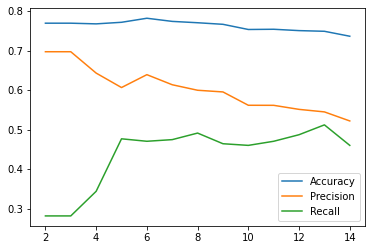

In [28]:
# Visualize the performance in a plot
plt.plot(depth_tuning_df['Max_depth'], depth_tuning_df['Accuracy'], label = 'Accuracy')
plt.plot(depth_tuning_df['Max_depth'], depth_tuning_df['Precision'], label = 'Precision')
plt.plot(depth_tuning_df['Max_depth'], depth_tuning_df['Recall'], label = 'Recall')
plt.legend()
plt.show()

From the plot, it seems that 6 is a good choice for the tree depth, since it got higher accuracy and precision but also has a good recall. It means that it can well identify churn customers well as well as classify the churn customers.

### (2) Using Logistic Regression Model

**Introduction** \
Logistic regression is a supervised learning method and a statistical model used for classifing binary responses. It models log-odds of the probability of the target and returns coefficients and prediction probability.

$\log_b\frac{p}{1-p} = \beta_0+\beta_1x_1+\beta_2x_2$

**Model Performance Metrics** \
- Accuracy: % of corrected predicted labels $\frac{TP+TN}{all}$
- Precision: % of total model's positive class prediction that were corrected classified $\frac{TP}{TP+FP}$
- Recall: % corrected predicted labels from real positive classed $\frac{TP}{TP+FN}$

**Regularization**
It addresses over-fitting when there are too many features by introducing a penalty coefficient for model complexity in the model building phase. 
- L1(LASSO) regularization can also perform feature selection
- L2



In `Churn` column, *1* represents to churn and *0* means the opposite.

In [11]:
# Copy the raw dataset
telcom = telco_raw.copy()

# Calculate the ratio size of each churn group
print(set(telcom['Churn']))
telcom.groupby(['Churn']).size()/telcom.shape[0] * 100

{0, 1}


Churn
0    73.421502
1    26.578498
dtype: float64

In [12]:
# Preparing data

# Get the training and testing data
train, test = train_test_split(telcom, test_size= 0.25)

# Store column names from `telcom` excluding target variable and customer ID
target = ['Churn']
custid = ['customerID']
cols = [col for col in telcom.columns if col not in custid + target]

# Extract training and testing features
train_X = train[cols]
test_X = test[cols]

# Extract training and testing target
train_Y = train[target]
test_Y = test[target]

In [13]:
train_X

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2672,0,-0.220905,-1.485788,-0.759151,1,0,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0
5356,0,-0.261649,-0.977209,-0.575617,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
6448,0,1.042158,1.324691,1.736646,1,0,0,1,0,1,...,0,1,0,1,1,0,1,0,1,0
761,0,-0.424625,0.812788,-0.165644,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0
90,0,-0.098673,0.573457,0.126576,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,1,1.612573,1.582305,2.542806,0,1,0,1,0,1,...,0,1,0,1,0,1,1,0,1,0
499,0,-0.832064,1.160151,-0.460975,0,0,0,1,0,1,...,0,0,0,1,0,0,1,0,0,0
6638,0,1.001414,-1.464182,-0.513763,1,0,0,1,0,0,...,1,0,1,0,0,1,0,0,0,1
3404,0,0.105047,-0.305753,-0.117731,0,0,1,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [14]:
# Initial model

# Fit logistic regression on training data
logreg = LogisticRegression()
logreg.fit(train_X, train_Y)

# Predict churn labels on testing data
pred_test_Y = logreg.predict(test_X)

# Calculate accuracy score
test_accuracy = accuracy_score(test_Y, pred_test_Y)
print('Test accuracy:', round(test_accuracy,4))

Test accuracy: 0.8117


/Users/alliewu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [17]:
# Logistic regression with L1 regularization

# Initialize logistic regression instance
logreg_l1 = LogisticRegression(penalty='l1', 
                                C=0.01, solver='liblinear')

# Fit the model
logreg_l1.fit(train_X, train_Y)

# Predict for test_Y
pred_test_Y = logreg_l1.predict(test_X)

# Calculate accuracy score
print('Test accuracy:', round(accuracy_score(test_Y,pred_test_Y),4))

Test accuracy: 0.7907


/Users/alliewu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [16]:
# Identify optimal L1 penalty coefficient

# Create possible C list
C = [1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025]
l1_metrics = np.zeros((len(C), 3))
l1_metrics[:,0] = C
print(l1_metrics)

# Run a for loop over the range of C list length
for index in range(0,len(C)):
    logreg_l1 = LogisticRegression(penalty='l1', C=C[index], solver='liblinear')
    logreg_l1.fit(train_X,train_Y)
    pred_test_Y = logreg_l1.predict(test_X)
    # non-zero count
    l1_metrics[index,1] = np.count_nonzero(logreg_l1.coef_)
    # recall score
    l1_metrics[index,2] = recall_score(test_Y, pred_test_Y)

# Name the columns and print the array as pandas DataFrame
col_names = ['C','Non-Zero Coeffs','Recall']
print(pd.DataFrame(l1_metrics, columns=col_names))

[[1.     0.     0.    ]
 [0.5    0.     0.    ]
 [0.25   0.     0.    ]
 [0.1    0.     0.    ]
 [0.05   0.     0.    ]
 [0.025  0.     0.    ]
 [0.01   0.     0.    ]
 [0.005  0.     0.    ]
 [0.0025 0.     0.    ]]


/Users/alliewu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/alliewu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/alliewu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/alliewu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

        C  Non-Zero Coeffs    Recall
0  1.0000             28.0  0.526971
1  0.5000             29.0  0.526971
2  0.2500             21.0  0.522822
3  0.1000             18.0  0.520747
4  0.0500             17.0  0.495851
5  0.0250             13.0  0.462656
6  0.0100              7.0  0.398340
7  0.0050              3.0  0.321577
8  0.0025              2.0  0.000000


In [20]:
# Build a model with tuned parameter C = 0.025

# Initialize logistic regression instance
logreg_l1_tuned = LogisticRegression(penalty='l1', 
                                C=0.025, solver='liblinear')

# Fit the model
logreg_l1_tuned.fit(train_X, train_Y)

# Predict for test_Y
pred_test_Y = logreg_l1_tuned.predict(test_X)

# Calculate accuracy score
print('Test accuracy:', round(accuracy_score(test_Y,pred_test_Y),4))

Test accuracy: 0.7992


/Users/alliewu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
